### **1. Import necessary libraries and modules**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os

from custom_loss_functions import SCCE, SCCEInverse, SCCEMinMaxBin, SCCEMaxBin, SCCEDifference, SCCEMaxBinVanilla
from custom_layers import DefaultDense, RowWiseQuantized, RowWiseQuantizedSTE, ColumnWiseQuantized, ColumnWiseQuantizedSTE
from custom_callbacks import ScaleTrackingCallback, AccuracyLossTrackingCallBack, LossTrackingCallbackNew
from utils import print_model_structure, count_unique_values, count_unique_values_and_plot_histograms, count_unique_values_2

from datetime import datetime

from plot_scripts import plot_loss, plot_pareto_accuracy, plot_pareto_loss, plot_accuracy_loss, plot_pareto_losses, plot_pareto_accuracies

### **2. Import MNIST data:**

In [2]:
# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)  # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

### **3. Define model layers**

The custom `RowWiseQuantizedSTE` can be replaced with other custom layer classes. Refer to `custom_layers.py`.

In [3]:
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [4]:
def initialize_quantized_model(log_dir, input_shape=(28, 28, 1), seed=42):
    set_seed(seed)

    input_layer = tf.keras.Input(shape=input_shape)
    flatten_layer = tf.keras.layers.Flatten()(input_layer)
    quantized_dense_layer = RowWiseQuantized(128, log_dir)(flatten_layer)
    quantized_dense_layer_2 = tf.keras.activations.relu(quantized_dense_layer)
    output_layer = RowWiseQuantized(10, log_dir)(quantized_dense_layer_2)
    output_layer_2 = tf.keras.activations.softmax(output_layer)

    quantized_model = tf.keras.Model(inputs=input_layer, outputs=output_layer_2)

    return quantized_model

### **4. Print model structure for timely inspection**

In [5]:
def prepare_model_dir(penalty_rate, learning_rate, run_timestamp, loss_func):
    log_dir = f'logs/{run_timestamp}_pr_{penalty_rate}_lr_{learning_rate}_{loss_func.__name__}'
    os.makedirs(log_dir)
    return log_dir

### **5. Initialize a custom loss function and compile the model**
The `SCCEMinMaxBin` can be replaced with other loss function objects. Refer to `custom_loss_functions.py`. Note that only `SCCEMinMaxBin` and `SCCEMaxBin` take the `row_wise` argument.

In [6]:
def initialize_loss_function(model, penalty_rate, log_dir, loss_func=SCCEMaxBin):

    loss_function = loss_func(
        layers=[
            model.get_layer(index=2),
            model.get_layer(index=3)
        ],
        penalty_rate=penalty_rate,
        row_wise=1,  # 1 = True = scale factor values are applied row-wise
        log_dir=log_dir
    )
    
    return loss_function



def compile_model(model, learning_rate, loss_function):
    # Compile your models
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss_function.compute_total_loss,
        metrics=['accuracy']
    )

### **6. Initialize callbacks, train and evaluate the model**

In [7]:
def initialize_callbacks(model, loss_function, log_dir, validation_data):
    # Initialize your callbacks
    scale_tracking_callback_first_dense_layer = ScaleTrackingCallback(model.get_layer(index=2), log_dir)
    scale_tracking_callback_second_dense_layer = ScaleTrackingCallback(model.get_layer(index=3), log_dir)
    penalty_callback = LossTrackingCallbackNew(loss_function=loss_function, validation_data=validation_data, interval=val_interval, log_dir=log_dir)
    accuracy_callback = AccuracyLossTrackingCallBack(model.get_layer(index=3), log_dir)

    # Return callbacks as a dictionary
    callbacks = {
        'scale_tracking_callback_first_dense_layer': scale_tracking_callback_first_dense_layer,
        'scale_tracking_callback_second_dense_layer': scale_tracking_callback_second_dense_layer,
        'penalty_callback': penalty_callback,
        'accuracy_callback': accuracy_callback
    }

    return callbacks

def train_model(model, epochs, validation_data, batch_size, **callbacks):
    # Train your model
    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        validation_data=validation_data,
        callbacks=list(callbacks.values()),  
        batch_size=batch_size
    )

    return history

def evaluate_model(model):
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f'Quantized Model Test Accuracy: {accuracy}')
    return accuracy

In [8]:
#penalty_rate = 0.0000000001
penalty_rates = [
    0.0001,    
]

learning_rate = 0.00005
validation_data = (x_test, y_test)
epochs = 100
val_interval = 75
batch_size = 32
run_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
loss_func = SCCEDifference

log_dirs = []


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <InputLayer name=input_layer, built=True>
  - Input Shape: []
  - Output Shape: <KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=keras_tensor>

LAYER 1: <Flatten name=flatten, built=True>
  - Input Shape: <KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=keras_tensor>
  - Output Shape: <KerasTensor shape=(None, 784), dtype=float32, sparse=False, name=keras_tensor_1>

LAYER 2: <RowWiseQuantized name=row_wise_quantized, built=True>
  - Input Shape: <KerasTensor shape=(None, 784), dtype=float32, sparse=False, name=keras_tensor_1>
  - Output Shape: <KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_2>
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <RowWiseQuantized name=row_wise_quantized_1, built=True>
  - Input Shape: <KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=kera

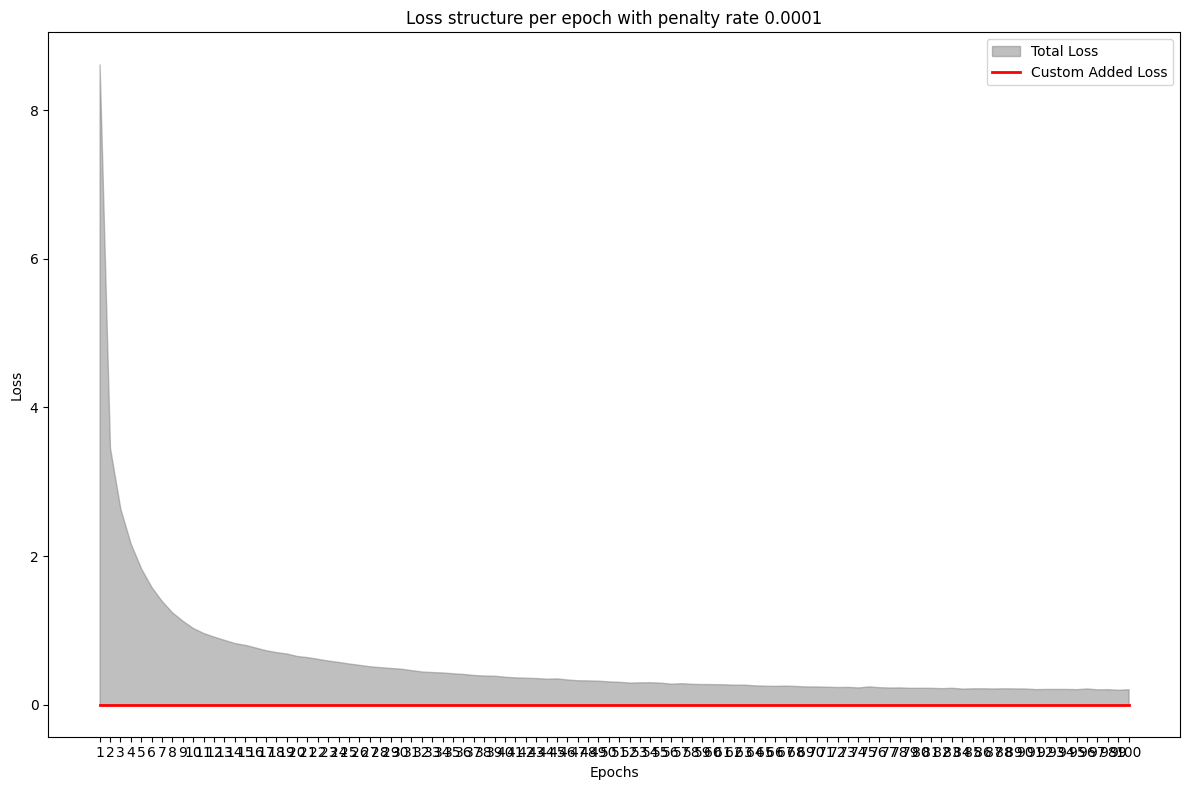


--------------------------------------------------------------------------------
NUMBER OF UNIQUE VALUES FOR W AND B OF EACH CUSTOM LAYER

LAYER WITH ID: 0 DOESN'T HAVE SCALE FACTOR VALUES OR MEANINGFUL ONES

LAYER WITH ID: 1 DOESN'T HAVE SCALE FACTOR VALUES OR MEANINGFUL ONES

LAYER WITH ID: 2
Unique values in w:  73218
Unique values in quantized w:  9
Min abs value in quantized w:  0.0
Max abs value in quantized w:  4.0
The values:  [-4. -3. -2. -1.  0.  1.  2.  3.  4.] 

Unique values in b:  123
Unique values in quantized b:  2
Min abs value in quantized b:  0.0
Max abs value in quantized b:  1.0
The values:  [-1.  0.] 

LAYER WITH ID: 3
Unique values in w:  1221
Unique values in quantized w:  8
Min abs value in quantized w:  0.0
Max abs value in quantized w:  5.0
The values:  [-5. -4. -3. -2. -1.  0.  1.  2.] 

Unique values in b:  10
Unique values in quantized b:  2
Min abs value in quantized b:  0.0
Max abs value in quantized b:  1.0
The values:  [-1.  0.] 


-------------------

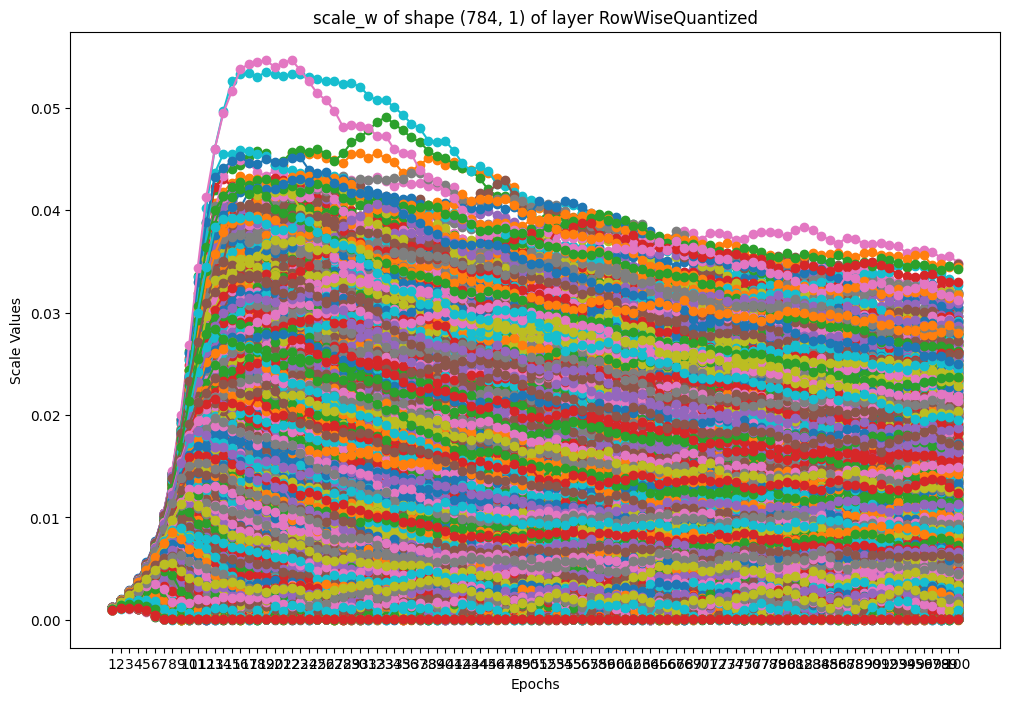

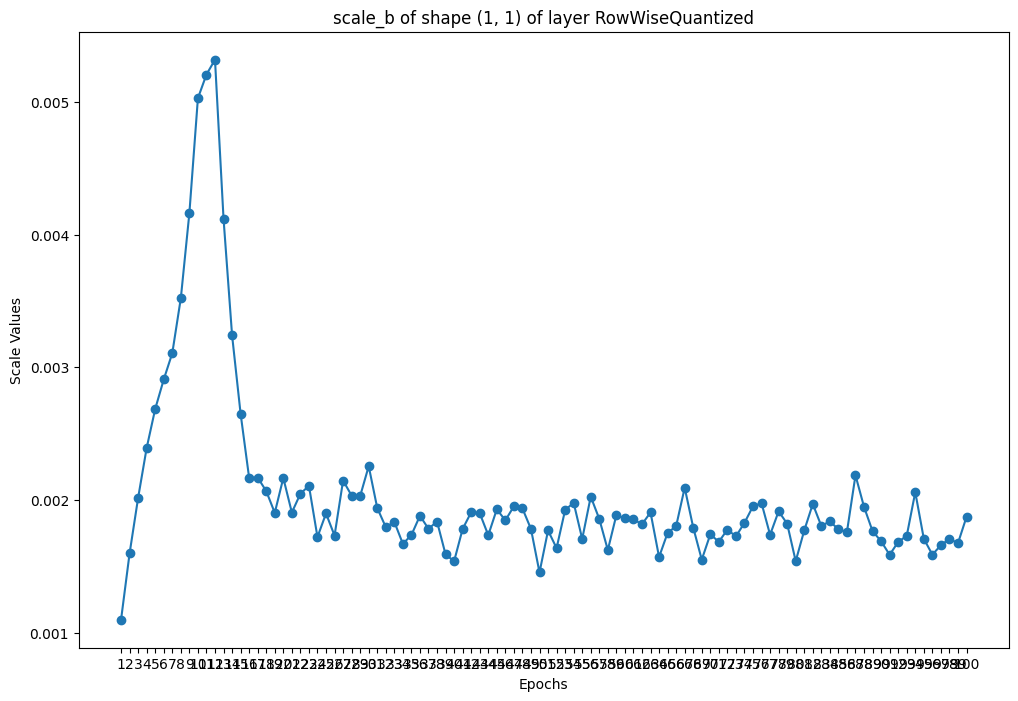

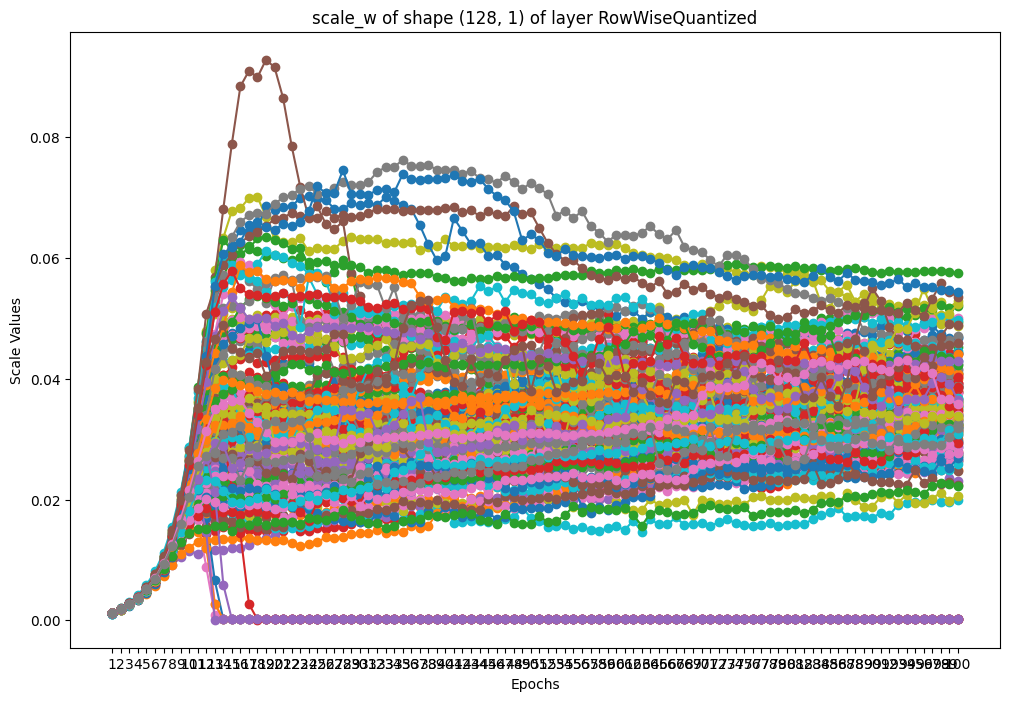

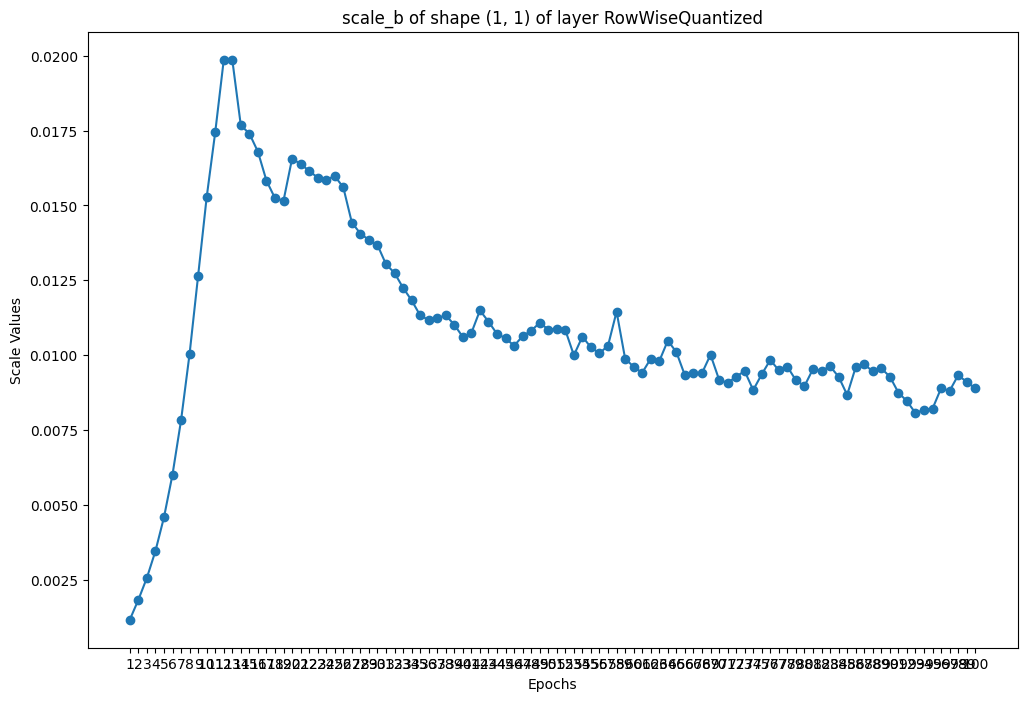

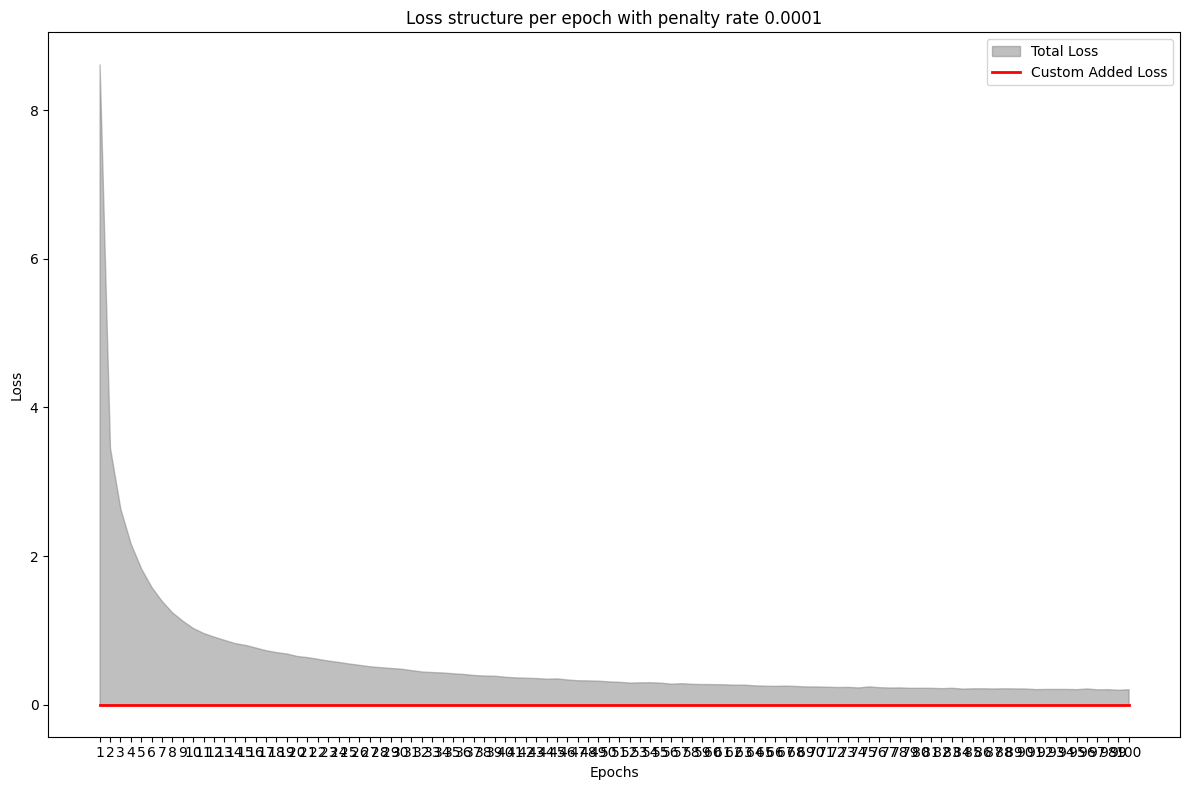

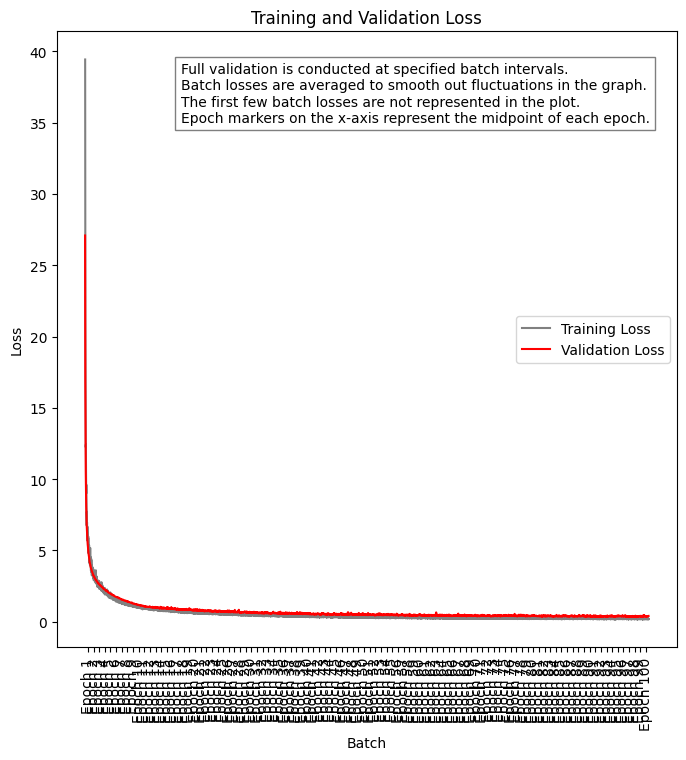

100


/Users/anuunchinbat/Desktop/Thesis/qat_2/plot_scripts.py:622: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Plot saved to logs/2024-10-15_14-53-55_pr_0.0001_lr_5e-05_SCCEDifference/plots/pareto_optimality_accuracy_plot.png


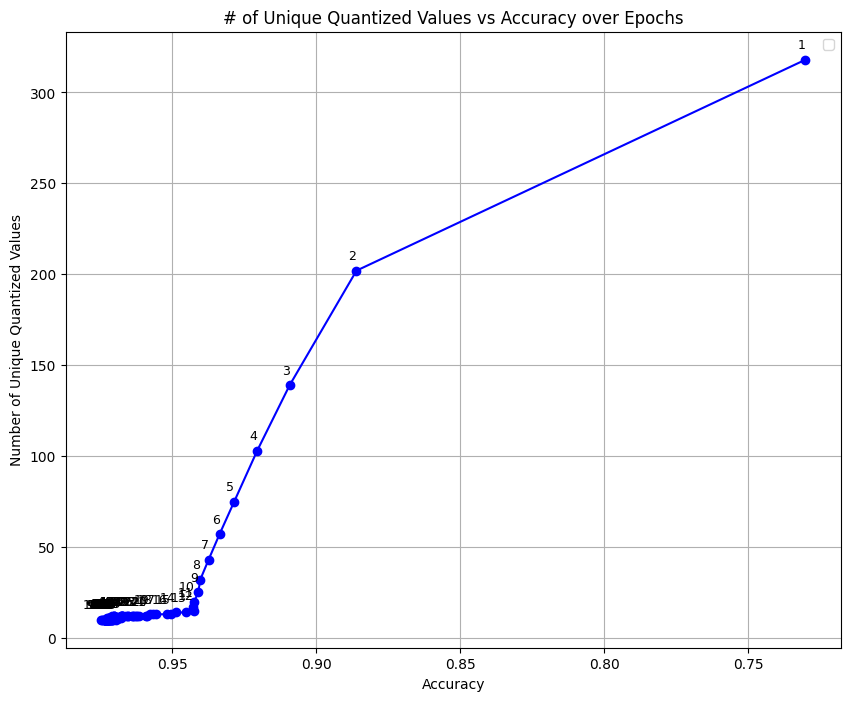

100


/Users/anuunchinbat/Desktop/Thesis/qat_2/plot_scripts.py:673: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Plot saved to logs/2024-10-15_14-53-55_pr_0.0001_lr_5e-05_SCCEDifference/plots/pareto_optimality_loss_plot.png


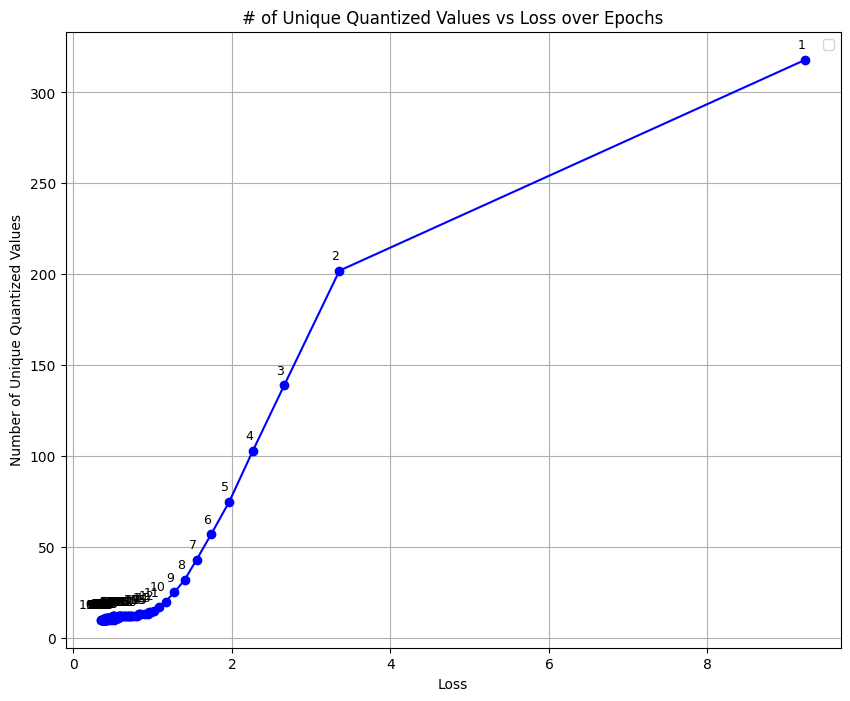

Accuracy plot saved to: logs/2024-10-15_14-53-55_pr_0.0001_lr_5e-05_SCCEDifference/accuracy_plot.png
Loss plot saved to: logs/2024-10-15_14-53-55_pr_0.0001_lr_5e-05_SCCEDifference/loss_plot.png


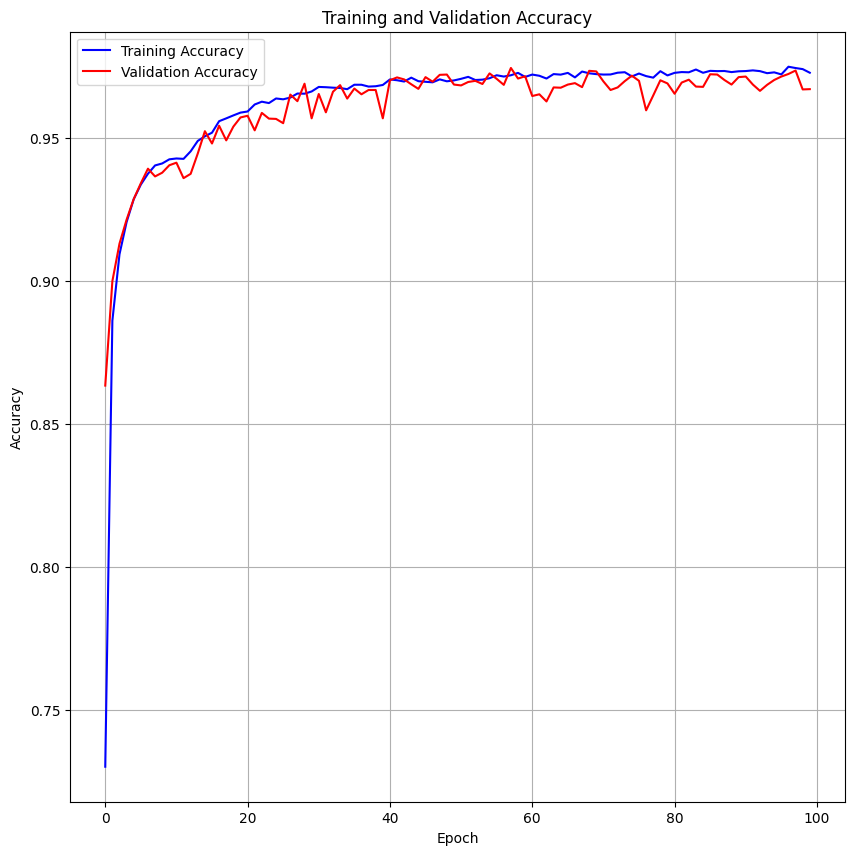

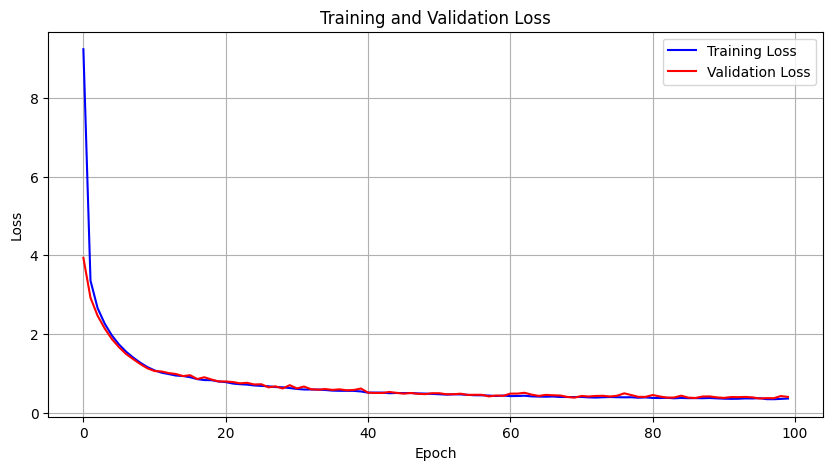

In [9]:
for penalty_rate in penalty_rates:
    log_dir = prepare_model_dir(penalty_rate=penalty_rate, learning_rate=learning_rate, run_timestamp = run_timestamp, loss_func = loss_func)
    log_dirs.append(log_dir)

    quantized_model = initialize_quantized_model(log_dir,input_shape=(28,28,1), seed=1234)

    print_model_structure(quantized_model, log_dir, filename="quantized_model_structure.txt")

    loss_function = initialize_loss_function(
        model=quantized_model, 
        penalty_rate=penalty_rate, 
        log_dir=log_dir,
        loss_func=loss_func
    )    

    compile_model(
        model=quantized_model, 
        learning_rate=learning_rate, 
        loss_function=loss_function
    )    

    callbacks = initialize_callbacks(
        model=quantized_model, 
        loss_function=loss_function, 
        validation_data=validation_data,
        log_dir=log_dir
    )    

    history = train_model(
        model=quantized_model, 
        epochs=epochs, 
        validation_data=validation_data,
        batch_size=batch_size,
        **callbacks
    )

    accuracy = evaluate_model(model=quantized_model)
    plot_loss(log_dir, x_train_size=len(x_train), batch_size=batch_size, penalty_rate=penalty_rate)
    count_unique_values(quantized_model,folder_name = log_dir)

    from plot_scripts import plot_training_validation_loss, plot_scale_values, plot_loss, plot_accuracy, plot_unique_values_accuracy

    # Plot scale values of first dense layer
    plot_scale_values(quantized_model.get_layer(index=2), log_dir)
    plot_scale_values(quantized_model.get_layer(index=3), log_dir)
    plot_loss(log_dir, x_train_size=len(x_train), batch_size=batch_size, penalty_rate=penalty_rate)
    plot_training_validation_loss(log_dir, interval=val_interval, epochs=epochs, x_train_size=len(x_train), batch_size=batch_size)

    plot_pareto_accuracy(
        f'{log_dir}/accuracy.log', 
        f'{log_dir}/unique_combined_RowWiseQuantized_w_b.log',
        f'{log_dir}/plots/', 
    )

    plot_pareto_loss(
        f'{log_dir}/loss.log', 
        f'{log_dir}/unique_combined_RowWiseQuantized_w_b.log',
        f'{log_dir}/plots/', 
    )

    plot_accuracy_loss(log_dir)


In [10]:
list_of_dirs = [
    "2024-10-14_22-03-51_pr_0.0_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_22-03-51_pr_1e-10_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_22-03-51_pr_1e-09_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_22-03-51_pr_1e-08_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_22-03-51_pr_1e-07_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_22-03-51_pr_1e-06_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_22-03-51_pr_1e-05_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_22-03-51_pr_0.0001_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_22-03-51_pr_0.001_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_22-03-51_pr_0.01_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_22-03-51_pr_0.1_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_22-03-51_pr_1.0_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_22-03-51_pr_10.0_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_22-03-51_pr_100.0_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_22-03-51_pr_1000.0_lr_5e-05_SCCEMaxBinVanilla",    
]

list_of_dirs_loss = [
    [
        f"logs/{dir}/loss.log",
        f"logs/{dir}/unique_combined_RowWiseQuantized_w_b.log",
        f"logs/{dir}/plots/"
    ]
    for dir in list_of_dirs
]


list_of_dirs_accuracy = [
    [
        f"logs/{dir}/accuracy.log",
        f"logs/{dir}/unique_combined_RowWiseQuantized_w_b.log",
        f"logs/{dir}/plots/"
    ]
    for dir in list_of_dirs    
]

print(list_of_dirs_loss)

[['logs/2024-10-14_22-03-51_pr_0.0_lr_5e-05_SCCEMaxBinVanilla/loss.log', 'logs/2024-10-14_22-03-51_pr_0.0_lr_5e-05_SCCEMaxBinVanilla/unique_combined_RowWiseQuantized_w_b.log', 'logs/2024-10-14_22-03-51_pr_0.0_lr_5e-05_SCCEMaxBinVanilla/plots/'], ['logs/2024-10-14_22-03-51_pr_1e-10_lr_5e-05_SCCEMaxBinVanilla/loss.log', 'logs/2024-10-14_22-03-51_pr_1e-10_lr_5e-05_SCCEMaxBinVanilla/unique_combined_RowWiseQuantized_w_b.log', 'logs/2024-10-14_22-03-51_pr_1e-10_lr_5e-05_SCCEMaxBinVanilla/plots/'], ['logs/2024-10-14_22-03-51_pr_1e-09_lr_5e-05_SCCEMaxBinVanilla/loss.log', 'logs/2024-10-14_22-03-51_pr_1e-09_lr_5e-05_SCCEMaxBinVanilla/unique_combined_RowWiseQuantized_w_b.log', 'logs/2024-10-14_22-03-51_pr_1e-09_lr_5e-05_SCCEMaxBinVanilla/plots/'], ['logs/2024-10-14_22-03-51_pr_1e-08_lr_5e-05_SCCEMaxBinVanilla/loss.log', 'logs/2024-10-14_22-03-51_pr_1e-08_lr_5e-05_SCCEMaxBinVanilla/unique_combined_RowWiseQuantized_w_b.log', 'logs/2024-10-14_22-03-51_pr_1e-08_lr_5e-05_SCCEMaxBinVanilla/plots/'], [

Loss length: 100
Loss length: 100
Loss length: 100
Loss length: 100
Loss length: 100
Loss length: 100
Loss length: 100
Loss length: 100
Loss length: 100
Loss length: 100
Loss length: 100
Loss length: 100
Loss length: 100
Loss length: 100
Loss length: 100
Plot saved to logs/2024-10-14_22-03-51_pr_0.0_lr_5e-05_SCCEMaxBinVanilla/plots/pareto_optimality_losses_plot.png
Plot saved to logs/2024-10-14_22-03-51_pr_1e-10_lr_5e-05_SCCEMaxBinVanilla/plots/pareto_optimality_losses_plot.png
Plot saved to logs/2024-10-14_22-03-51_pr_1e-09_lr_5e-05_SCCEMaxBinVanilla/plots/pareto_optimality_losses_plot.png
Plot saved to logs/2024-10-14_22-03-51_pr_1e-08_lr_5e-05_SCCEMaxBinVanilla/plots/pareto_optimality_losses_plot.png
Plot saved to logs/2024-10-14_22-03-51_pr_1e-07_lr_5e-05_SCCEMaxBinVanilla/plots/pareto_optimality_losses_plot.png
Plot saved to logs/2024-10-14_22-03-51_pr_1e-06_lr_5e-05_SCCEMaxBinVanilla/plots/pareto_optimality_losses_plot.png
Plot saved to logs/2024-10-14_22-03-51_pr_1e-05_lr_5e-05_

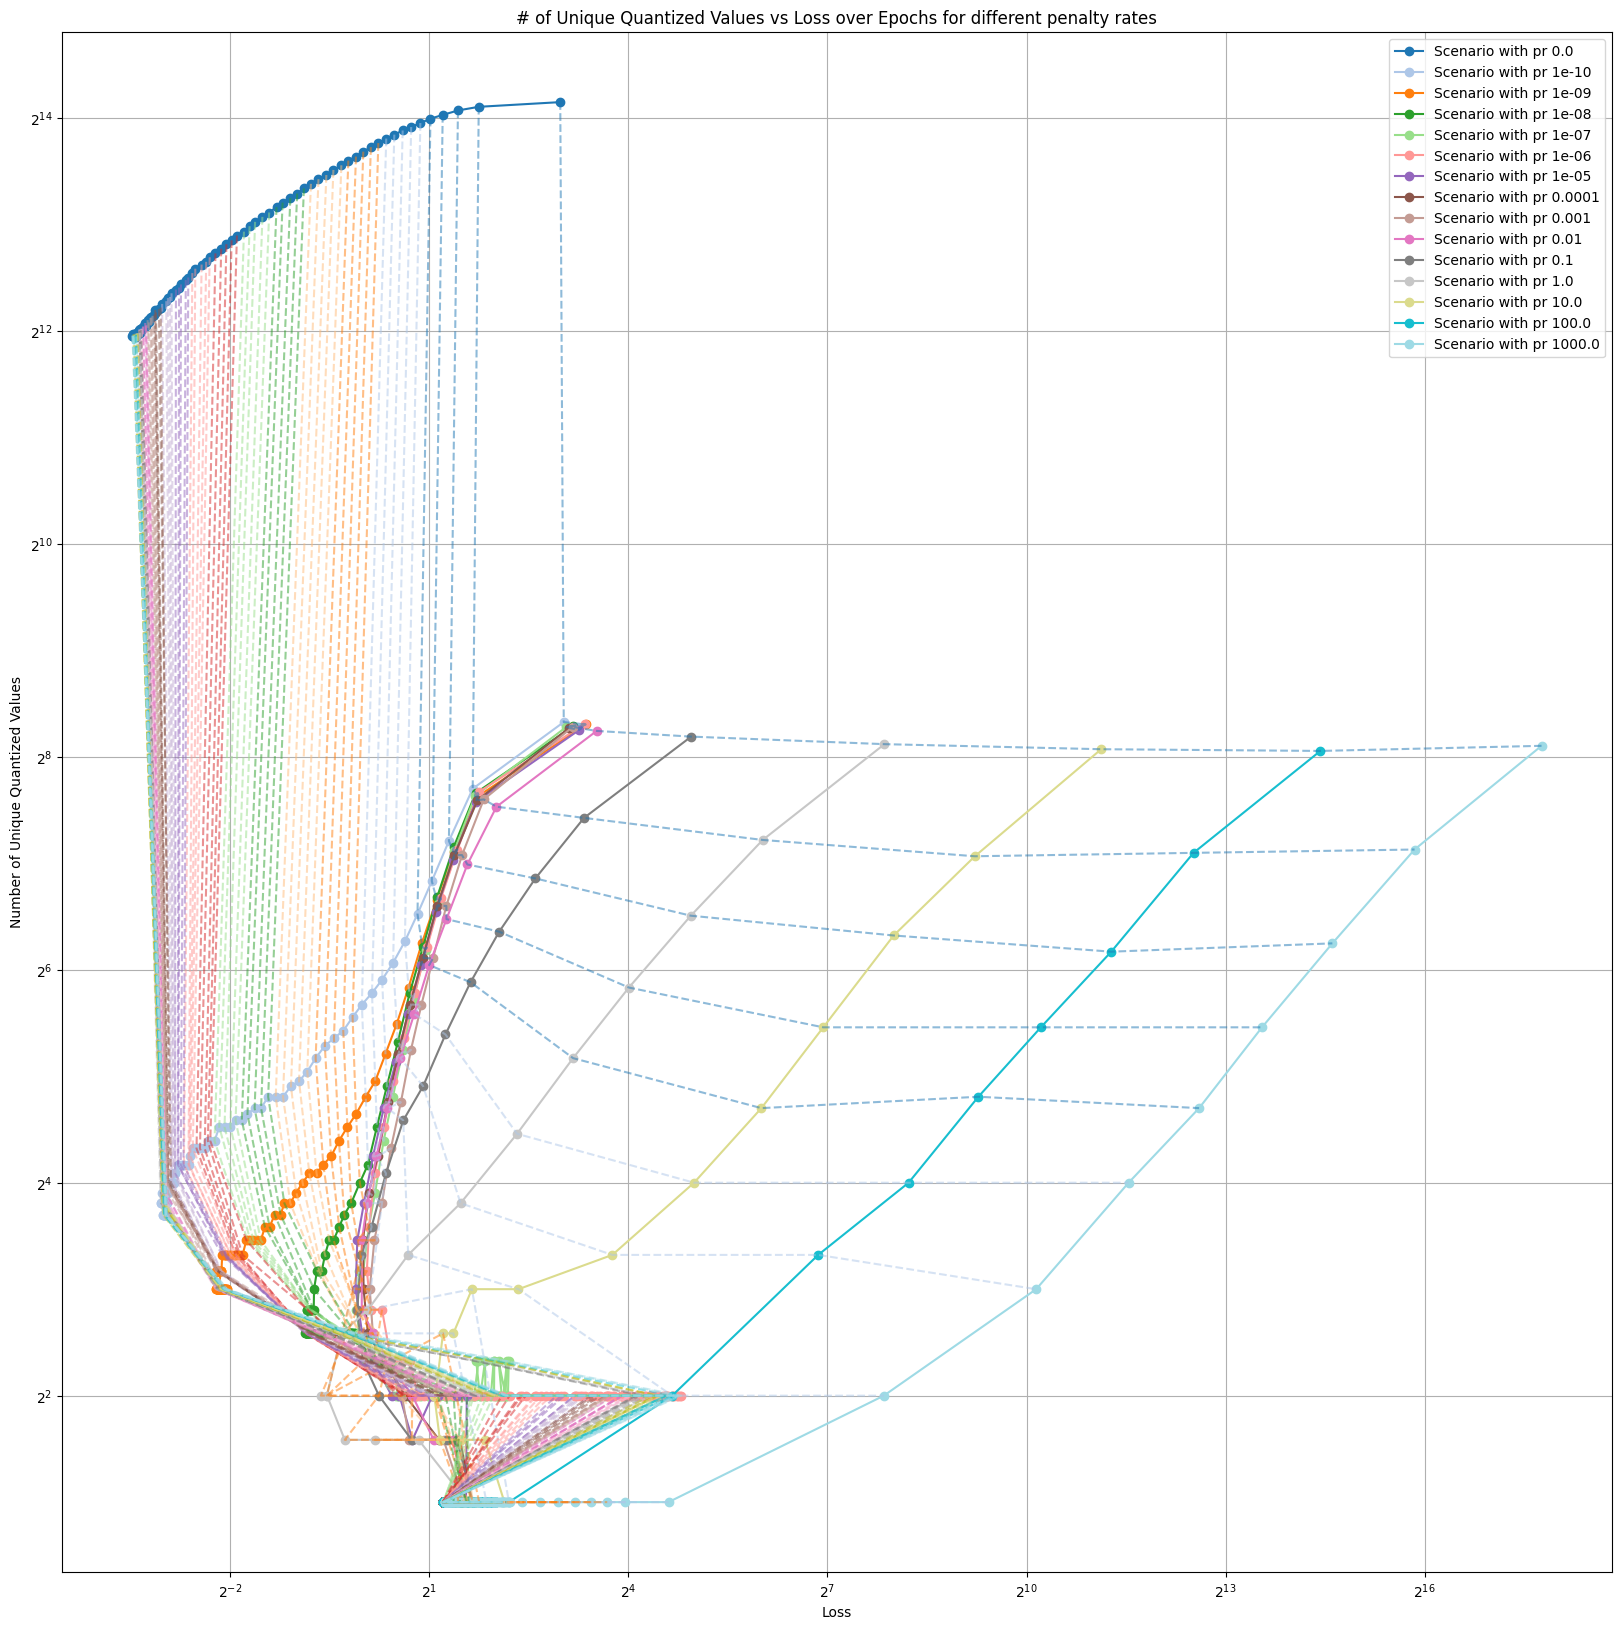

In [11]:

plot_pareto_losses(
    list_of_dirs_loss
)

Accuracy length: 100
Accuracy length: 100
Accuracy length: 100
Accuracy length: 100
Accuracy length: 100
Accuracy length: 100
Accuracy length: 100
Accuracy length: 100
Accuracy length: 100
Accuracy length: 100
Accuracy length: 100
Accuracy length: 100
Accuracy length: 100
Accuracy length: 100
Accuracy length: 100
Plot saved to logs/2024-10-14_22-03-51_pr_0.0_lr_5e-05_SCCEMaxBinVanilla/plots/pareto_optimality_accuracies_plot.png
Plot saved to logs/2024-10-14_22-03-51_pr_1e-10_lr_5e-05_SCCEMaxBinVanilla/plots/pareto_optimality_accuracies_plot.png
Plot saved to logs/2024-10-14_22-03-51_pr_1e-09_lr_5e-05_SCCEMaxBinVanilla/plots/pareto_optimality_accuracies_plot.png
Plot saved to logs/2024-10-14_22-03-51_pr_1e-08_lr_5e-05_SCCEMaxBinVanilla/plots/pareto_optimality_accuracies_plot.png
Plot saved to logs/2024-10-14_22-03-51_pr_1e-07_lr_5e-05_SCCEMaxBinVanilla/plots/pareto_optimality_accuracies_plot.png
Plot saved to logs/2024-10-14_22-03-51_pr_1e-06_lr_5e-05_SCCEMaxBinVanilla/plots/pareto_opti

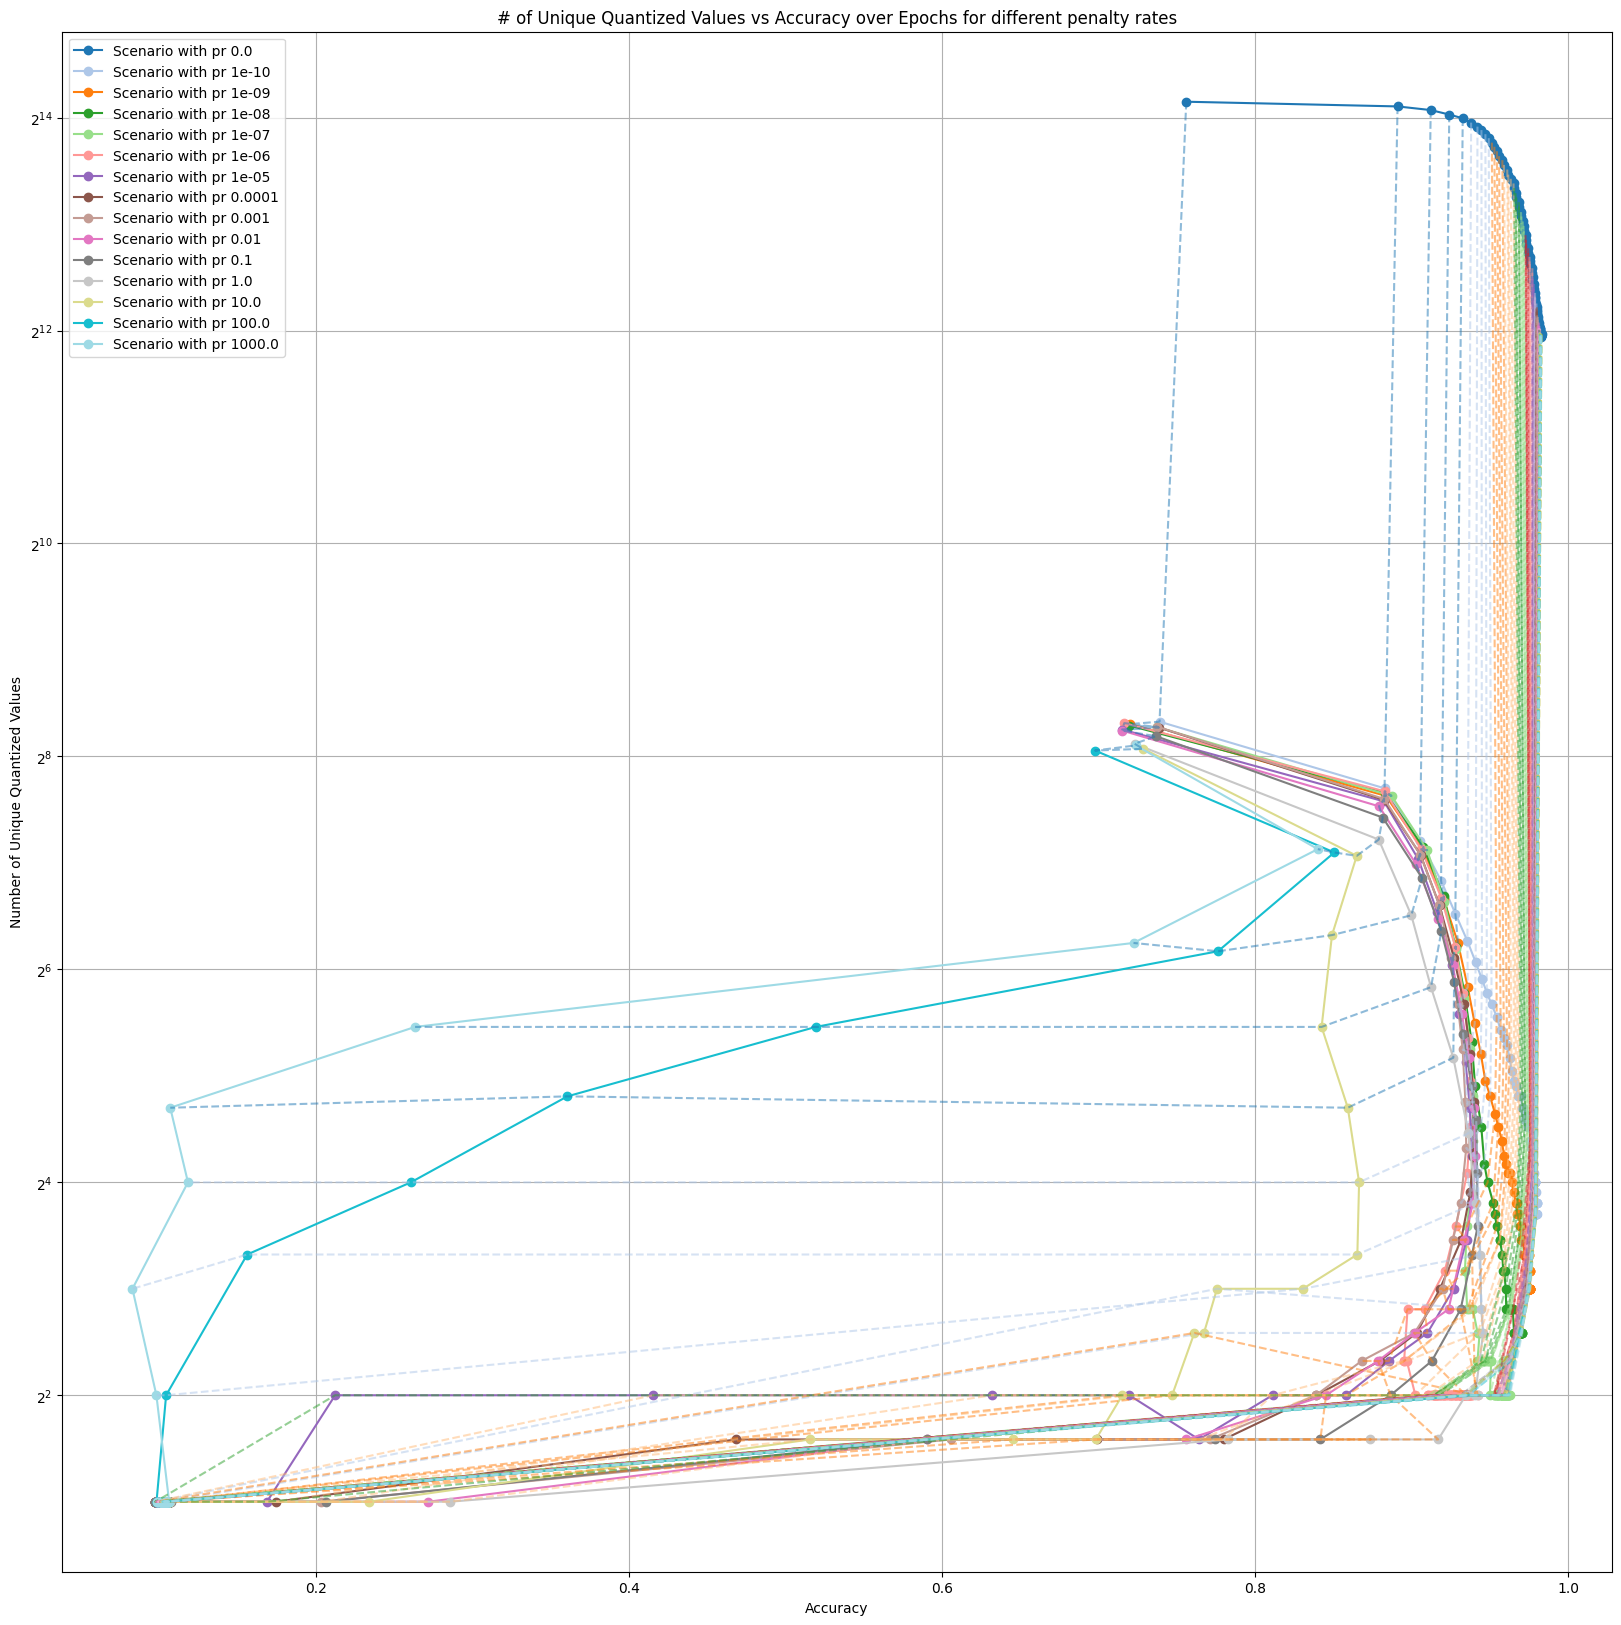

In [12]:
plot_pareto_accuracies(
    list_of_dirs_accuracy
)

In [13]:
to_compare = [
    "2024-10-14_22-03-51_pr_0.0_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_22-03-51_pr_0.0001_lr_5e-05_SCCEMaxBinVanilla",
    "2024-10-14_11-56-52_pr_0.0001_lr_5e-05_SCCEMaxBin",
]

to_compare_loss = [
    [
        f"logs/{dir}/loss.log",
        f"logs/{dir}/unique_combined_RowWiseQuantized_w_b.log",
        f"logs/intermediary_plots/"
    ]
    for dir in to_compare
]


to_compare_accuracy = [
    [
        f"logs/{dir}/accuracy.log",
        f"logs/{dir}/unique_combined_RowWiseQuantized_w_b.log",
        f"logs/intermediary_plots/"
    ]
    for dir in to_compare    
]

Accuracy length: 100
Accuracy length: 100
Accuracy length: 100
Plot saved to logs/intermediary_plots/pareto_optimality_accuracies_plot.png
Plot saved to logs/intermediary_plots/pareto_optimality_accuracies_plot.png
Plot saved to logs/intermediary_plots/pareto_optimality_accuracies_plot.png


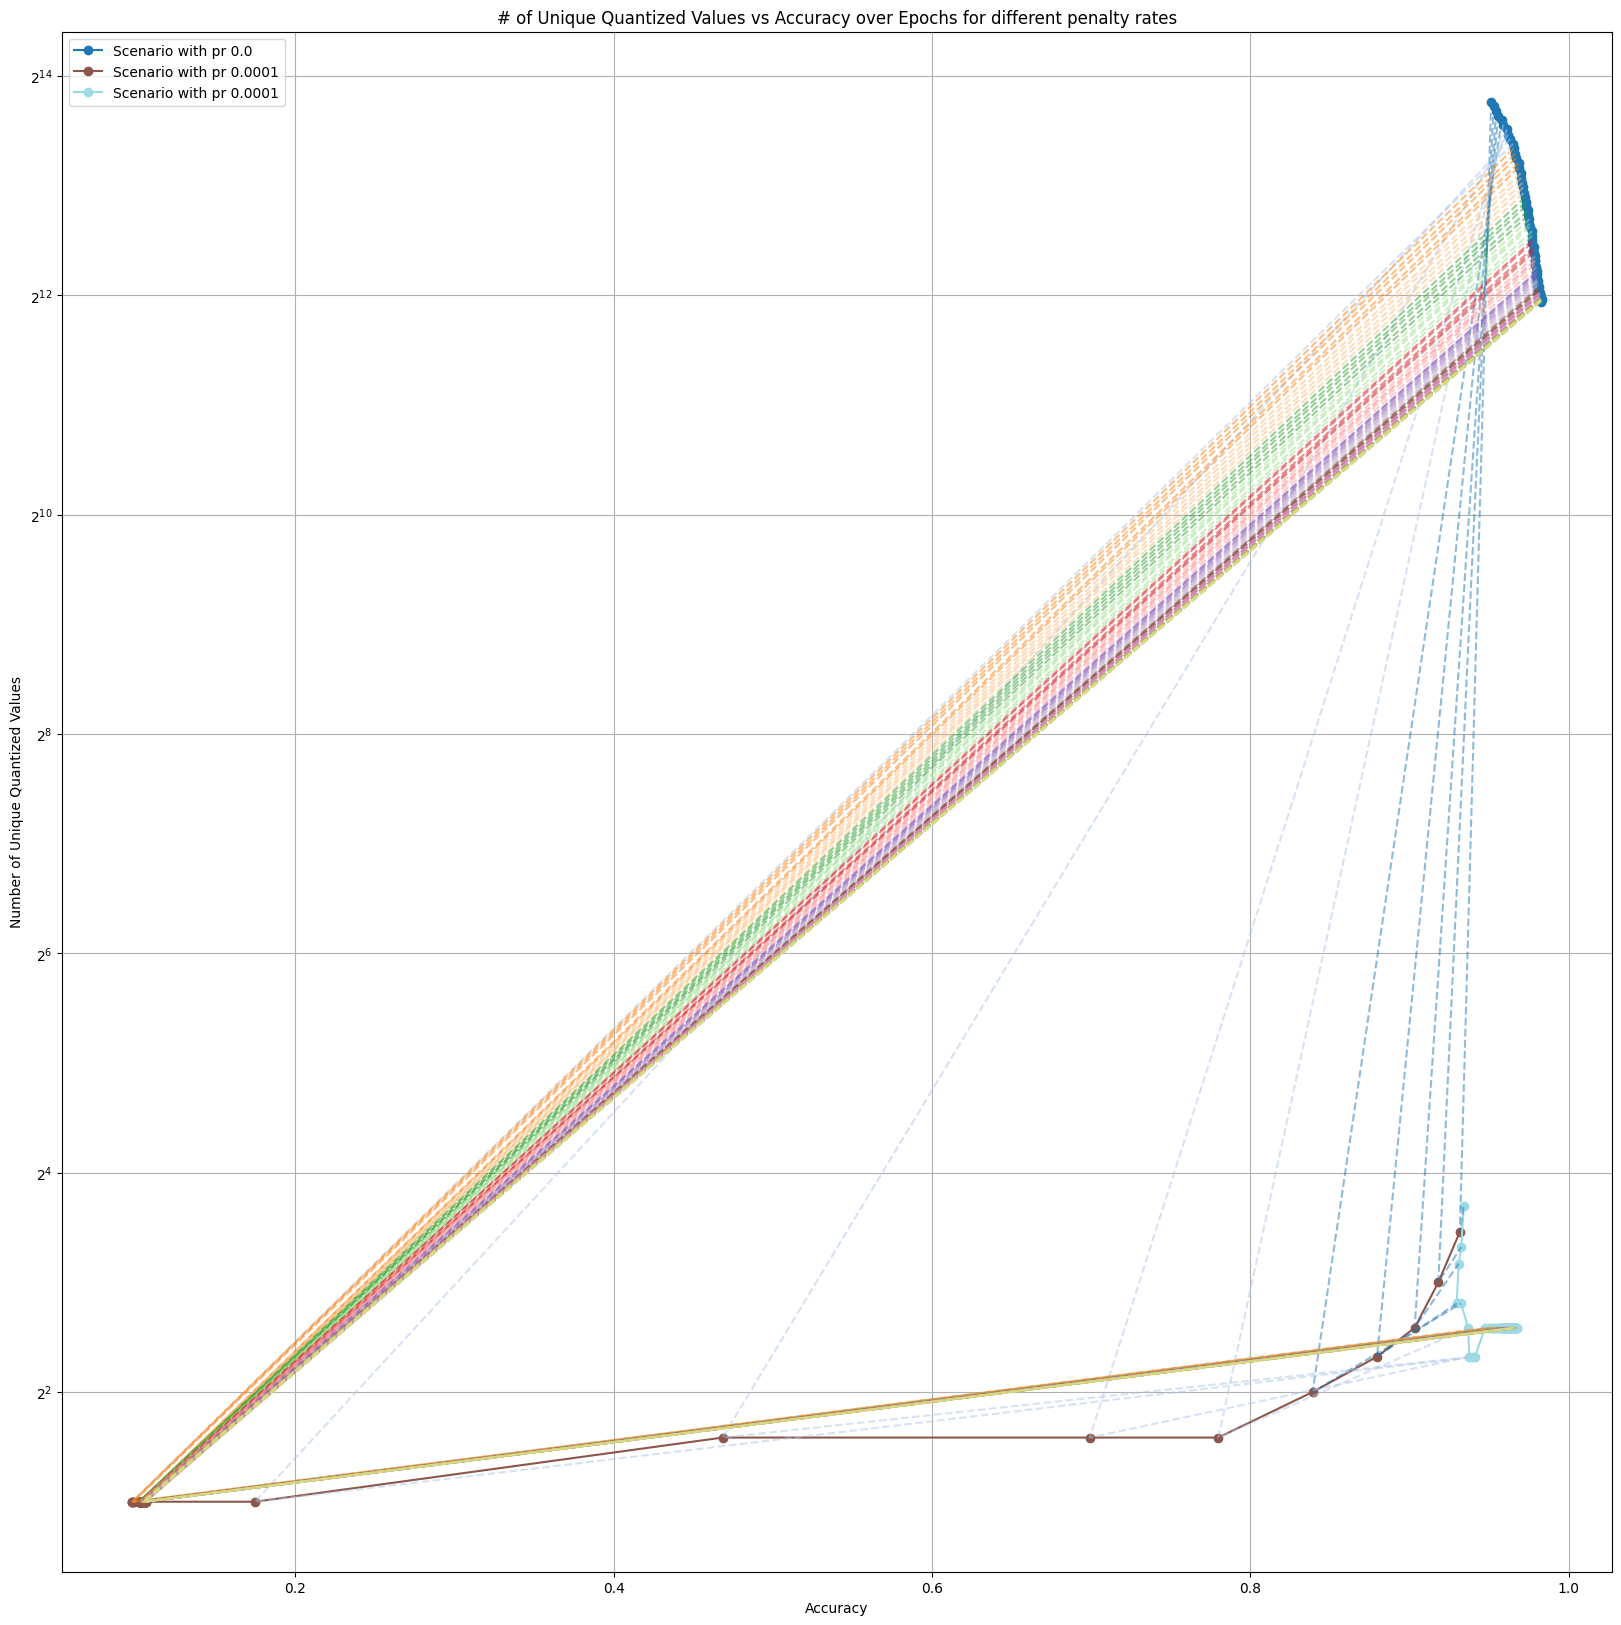

In [14]:
plot_pareto_accuracies(to_compare_accuracy, skip_epochs=10)

Loss length: 100
Loss length: 100
Loss length: 100
Plot saved to logs/intermediary_plots/pareto_optimality_losses_plot.png
Plot saved to logs/intermediary_plots/pareto_optimality_losses_plot.png
Plot saved to logs/intermediary_plots/pareto_optimality_losses_plot.png


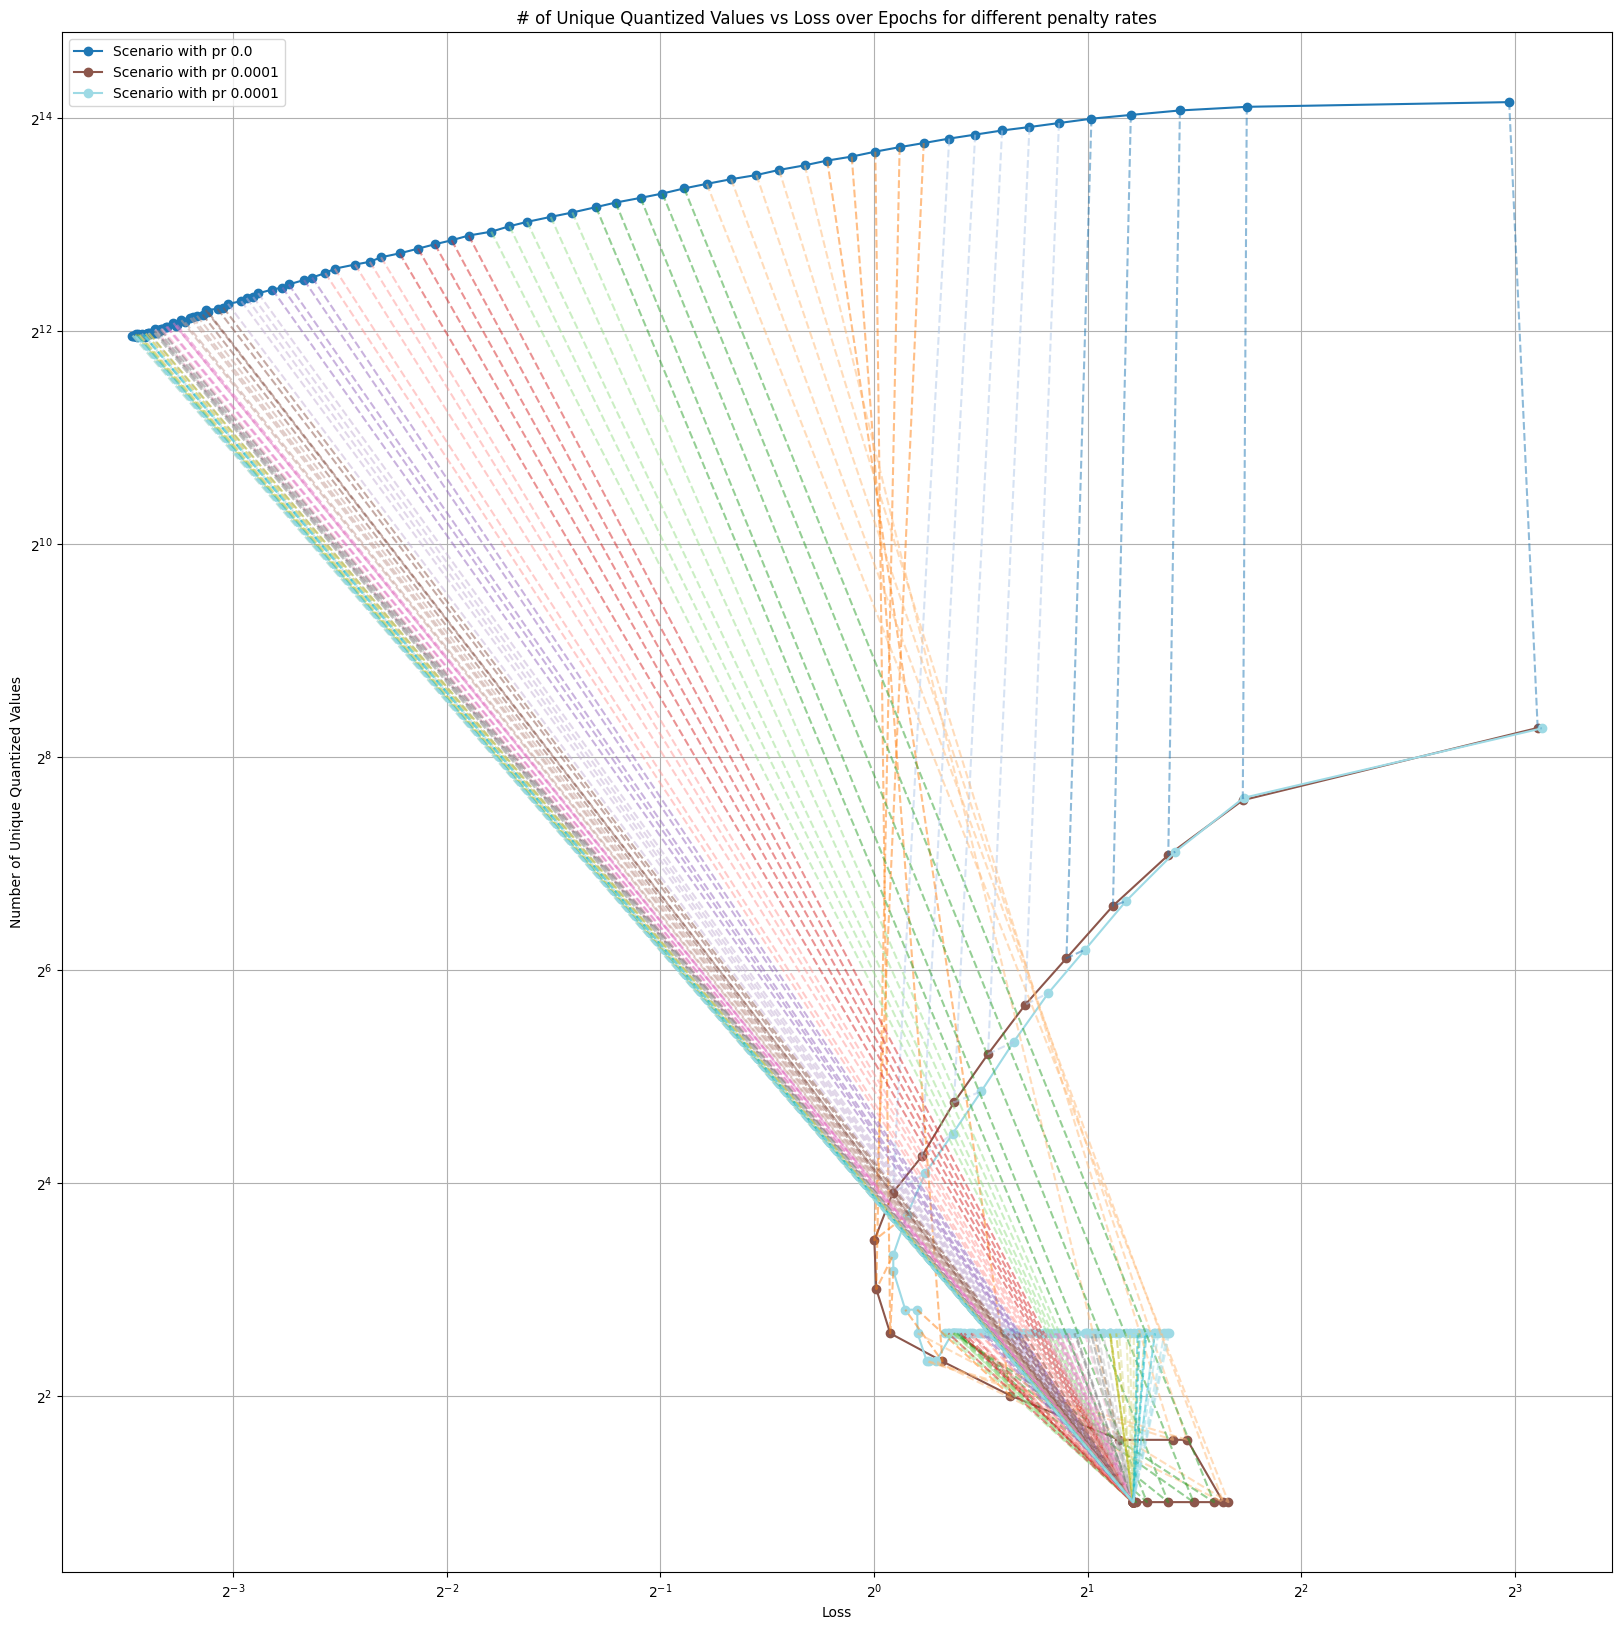

In [15]:
plot_pareto_losses(to_compare_loss)